In [1]:
## parameters for experiment
N_BLOCK = 5
#LR = 0.00001
LR = 0.001

OUTPUT_DIR = '20251115-CLA-MCU-Net-CE'

RANDOM_SEED = 42

IN_CHANNEL = 1

AUGMENTED = True
AUGMENTATION  =  30


CROSS_VAL = True
N_SPLIT = 4


#optimization constants
DICE_IMPORTANCE = 1.0
CE_IMPORTANCE = 1.0

In [2]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-11-16 01:05:59.552292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 01:06:00.287298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [4]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251115-CLA-MCU-Net-CE
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Net-CE


In [7]:
## feature list definition
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

# inputfeature_list = ["GRY_", "NML1", "NML2", "NML3", "NML1", "MEA1",
#                      "MEA2", "MED1", "MED2", "NML1", "NGP_", "KNN1",
#                      "KNN2", "BLT1", "BLT2", "UNS1", "UNS2", "UNS3",
#                      "UNS4", "UNS5", "ERO1", "ERO2", "ERO3", "ERO4",
#                      "ERO5", "ERO6", "OPN1", "OPN2", "OPN3", "OPN4",
#                      "OPN5", "CLO1", "CLO2", "CLO3", "CLO4", "CLO5",
#                      "MIN1", "MIN2", "MIN3", "MIN4", "MAX1", "MAX2",
#                      "MAX3", "MAX4", "MRL1", "MRL2", "MRL3", "MRL4",
#                      "RIC_",
#                      ]



# unet only
#inputfeature_list = inputfeature_list[:1]

#inputfeature_list.clear()

#inputfeature_list.append("RIC_")
#print(inputfeature_list)

#inputfeature_list.remove(OUTPUT_DIR[-4:])
# inputfeature_list.remove("TOP1")
# inputfeature_list.remove("TOP2")
# inputfeature_list.remove("TOP3")
# inputfeature_list.remove("TOP4")

# inputfeature_list.remove("SBLX")
# inputfeature_list.remove("SBLY")
# inputfeature_list.remove("SBLM")
# inputfeature_list.remove("SBLD")
# inputfeature_list.remove("SBL1")
# inputfeature_list.remove("SBL2")
# inputfeature_list.remove("SBL3")
# inputfeature_list.remove("SBL4")

# inputfeature_list.remove("LPL1")
# inputfeature_list.remove("LPL2")

# inputfeature_list.remove("LBP1")
# inputfeature_list.remove("LBP2")
# inputfeature_list.remove("LBP3")

# inputfeature_list.remove("SOL_")
# inputfeature_list.remove("OOO_")

# inputfeature_list.remove("CAN1")
# inputfeature_list.remove("CAN2")
# inputfeature_list.remove("CAN3")


# inputfeature_list.remove("FOU1")
# inputfeature_list.remove("FOU2")
# inputfeature_list.remove("FOU3")
# inputfeature_list.remove("FOU4")

# inputfeature_list.remove("SCH1")
# inputfeature_list.remove("SCH2")
# inputfeature_list.remove("SCH3")
# inputfeature_list.remove("SCH4")

# inputfeature_list.remove("ROB1")
# inputfeature_list.remove("ROB2")
# inputfeature_list.remove("ROB3")
# inputfeature_list.remove("ROB4")

# inputfeature_list.remove("MRG1")
# inputfeature_list.remove("MRG2")
# inputfeature_list.remove("MRG3")
# inputfeature_list.remove("MRG4")

# inputfeature_list.remove("BTM1")
# inputfeature_list.remove("BTM2")
# inputfeature_list.remove("BTM3")
# inputfeature_list.remove("BTM4")

# inputfeature_list.remove("DST_")
# inputfeature_list.remove("HOM_")

# for i in range(108):
#     stckd_feature_name = "NGP_" + inputfeature_list[i]
#     inputfeature_list.append(stckd_feature_name)

# for input_feature in inputfeature_list[:]:
#     if not input_feature.startswith("NGP"):
#         inputfeature_list.remove(input_feature)
        


print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [8]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, label_dataset


In [9]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [10]:
## create weight test example

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
## createweightimageforshow
# # # 重みを基づいて、MC画像を生成する
# # # function for showing MC image
# # # gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [12]:
## value extraction for visual mc
# # ## Netron app to extract the weight tensor
# # ## if the conv is 1x1 the tensor has 45 values
# # ## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
# def compute_mean_values(input_list):
#     """
#     Compute mean of 3x3 blocks in each channel of the input list.
    
#     Args:
#         input_list (list): A 4D list of shape (1, C, H, W).
        
#     Returns:
#         list: A 1D list of length C containing the mean values for each channel.
#     """
#     # Ensure the input is a 4D list
#     if not isinstance(input_list, list) or len(input_list) != 1:
#         raise ValueError("Expected input list of shape (1, C, H, W)")
    
#     channels = input_list[0]  # Get the channels (C, H, W)
    
#     if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
#         raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
#     mean_values = []
#     for channel in channels:
#         if not all(isinstance(row, list) for row in channel):
#             raise ValueError("Each channel must contain 2D lists.")
        
#         # Flatten the 2D channel to compute the mean
#         flattened = [value for row in channel for value in row]
#         mean_values.append(sum(flattened) / len(flattened))
    
#     return mean_values


In [13]:
## mc image visualization example
# ### 1X1-1029-23-n1-1
# ### JUST SINGLE VARIATION
# weight_tensor_1x1_1029_23_n1_1_example = [
#     [
#         [
#             [
#                 0.048620592802762985
#                 ...
#     ]
# ]

# input_number = ['N1-1']

# #single
# weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

# weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
# weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
# weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
# weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
# weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

# print(len(weight_cn))
# print(len(weight_cn1))
# print(len(weight_cn2))
# print(len(weight_cn3))
# print(len(weight_cn4))
# print(len(weight_cn5))

# CreateWeightImageforShow(weight_cn, input_number, "single")

# CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
# CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
# CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
# CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
# CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



In [14]:
## mc image visualization example
# weight_tensor = np.load("/home/eric/Documents/cervicalResearchIIP/result_test/20250420-MCU-Net-108/0420_MCU108_fold4_w.npy")

# # initial shape (3, 108, 3, 3) (out_channels, channels, height_convolution, width_convolution)
# # np.mean takes mean value of out_channels
# # [np.newaxis, :] shapes into (1, 108, 3, 3)
# weight_tensor = np.mean(weight_tensor, axis = 0)[np.newaxis, :]
# weight_tensor = weight_tensor.tolist()

# #f1
# #input_number = ["N1-1", "N1-7", "N1-9", "N2-3", "N2-7", "N2-10", "N3-1", "N3-8", "N3-10", "N4-8", "N5-4"]
# #f2
# #input_number = ["N1-2", "N1-5", "N1-10", "N2-4", "N3-2", "N3-4", "N3-5", "N3-9", "N4-3", "N4-9", "N5-2"]
# #f3
# #input_number = ["N1-3", "N1-4", "N1-10", "N2-1", "N2-5", "N2-8", "N3-3", "N3-7", "N4-4", "N4-5", "N4-6", "N5-1", "N5-6"]
# #f4
# input_number = ["N1-6", "N1-8", "N2-2", "N2-6", "N2-9", "N3-6", "N4-1", "N4-2", "N4-7", "N5-3", "N5-5"]

# # weight_tensor_converted = weight_tensor[0].tolist()

# # weight_tensor_dv1 = [weight_tensor_converted]
# # # print(weight_tensor_dv1.shape)
# weight_cn  = compute_mean_values(weight_tensor)

# CreateWeightImageforShow(weight_cn, input_number, "fold4")

In [15]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [16]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    #for direct loading
    dataset_train2 = SegmentationDataSet0(
                                        #inputs=dataset_original,
                                        inputs=input_dataset,
                                        targets=label_dataset,
                                        transform=transforms_training)
    # for lazy loading
    # dataset_train2 = SegmentationDataSet5(
    #                                     #inputs=dataset_original,
    #                                     feature_paths=input_dataset,
    #                                     label_paths=label_dataset,
    #                                     feature_num = IN_CHANNEL,
    #                                     transform=transforms_training)

    # dataloader training
    #rearranged in custom order so shuffle is false in normal case: true
    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                     batch_size = 2,
                                     shuffle=True)
                                     #num_workers=4,
                                     #pin_memory=True)
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
                                        targets=label_dataset_val,
                                        transform=transforms_val)
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 2,
                                     shuffle=False)
                                     #num_workers=4, # for faster training loads next batch while training
                                     #pin_memory=True)  # for faster training, keeps data in pinned memory
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)
    
    # printing parameter name of the model could be done for criterion too
    # for name, param in model.named_parameters():
    #     print(name, param.device, param.requires_grad)
        
        


    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    from customLoss import BoundaryDiceLoss

    from customLoss import BoundaryIOU
    from customLoss import FocalLoss
    from customLoss import CombinedLossV2
    from customLoss import CombinedLoss
    
    #criterion = FocalLoss()
    
    
    # criterion = CombinedLossV2()
    # criterion.to(device=device)

    #loss function
    #criterion = ConfusionPenaltyLoss(num_classes=11)
    # pytorch cross entropy loss function
    
    criterion = torch.nn.CrossEntropyLoss()
    
    #criterion = CombinedLossV2()
    #criterion.to(device)
    
    #criterion = EnsembleInspiredLoss()
    
    #custom dice loss
    #criterion = DiceLoss()
    
    #custom combination loss of dice and cross entropy
    # 40 60 ratio
    #criterion = DiceCELoss(dice_weight = DICE_IMPORTANCE, ce_weight = CE_IMPORTANCE)
    
    # pytorch bce loss 
    # criterion = BCEWithLogitsLoss()
    
    # custom combination log exp loss of dice and cross entropy
    # requires segmentation class number
    #criterion = ExponentialLogCE_DiceLoss(num_class = 11)

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    #Your case (instability)1e-4 or 3e-4
    # #Small dataset1e-4
    # Large dataset3e-4 to 1e-3
    # Transfer learning1e-5 to 1e-4
    # Training from scratch3e-4
    # Loss oscillating/spikingReduce current LR by 10x
    # oss not decreasingIncrease LR or check other issues
    
    # optimizer = torch.optim.Adam(
    # list(model.parameters()) ,  lr = LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    
    # start training
    #for combined
    training_losses, validation_losses, lr_rates, learning_curve = trainer.run_trainer()
    
    #logging to csv
    assert len(training_losses) == len(validation_losses) == len(lr_rates), \
        "Lengths of training, validation losses, and learning rates must match."

    # Create dataframe
    df = pd.DataFrame({
        "Epoch": list(range(1, len(training_losses) + 1)),
        "Training_Loss": training_losses,
        "Validation_Loss": validation_losses,
        "Learning_Rate": lr_rates
    })

    # Save to CSV
    df.to_csv(test_result_dir + f"/fold{fold}_log.csv", index = False)
    
    learning_curve.savefig(test_result_dir + f"/fold{fold}_learningcurve.png")
    
    print("***************************")

    
    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [18]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [19]:

## mConv_predict test function
import statistics
from denseCRF import noiseReduction
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        print("Using CPU instead of GPU")
        torch.device('cpu')

    model = UNet(in_channels=IN_CHANNEL,  # check the parameters
                out_channels=11,
                n_blocks=N_BLOCK,
                start_filters=32,
                activation='relu',
                normalization='instance', #use instance when "batch" size is less than 10? batch
                conv_mode='same',
                dim=2).to(device)

    model_dir = os.path.join("model", date_str)
    print("model_dir = ", model_dir)
    model_path = os.path.join(model_dir, f"model_fold_{fold}.pt") # load the model
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)

    model.eval()

    # create test dataset
    test_input_dataset, _ = CreateWeightImage(test_input_name)
 

    # convert to torch
    test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)


    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict
    output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


    plot_output_img = list()
    
    
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # save images
    for i, output_img in enumerate(output):
        #for checking the unique values of the result label
        labels = np.unique(output_img)

        output_image_path = os.path.join(fold_dir, f"{test_input_name[i]}.png")
        cv2.imwrite(output_image_path, output_img)
        
        # old writing when there was no stratifiedkfold
        # cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

        #print(labels)
        plot_output_img.append(output_img)


    Dice = cal_DiceMulitple(fold_dir, test_input_name)
    df = pd.DataFrame(Dice)
    df = df.T
    df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    
    postCRF = noiseReduction(output, test_input_name, labeled_dir, fold_dir, 0.8)
    
    DiceCRF = cal_DiceMulitple( fold_dir + "/crf", test_input_name)
    dfCRF = pd.DataFrame(DiceCRF)
    dfCRF = dfCRF.T
    dfCRF.to_csv(test_result_dir + "/CRFDice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    

    



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

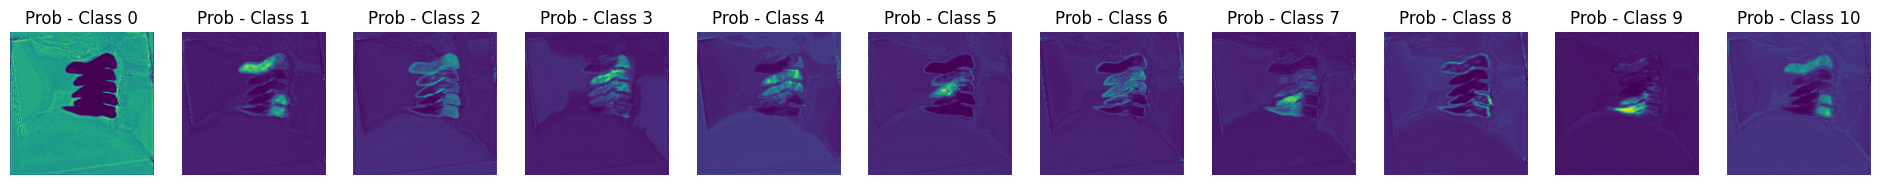

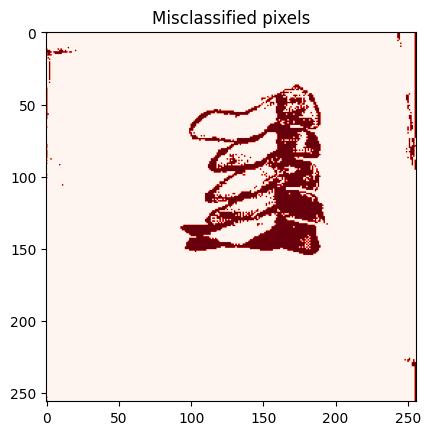

train_losses 1.4628418853788665
val_losses 1.079732341116125
lr 0.0001
Validation loss decreased (inf --> 1.079732).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

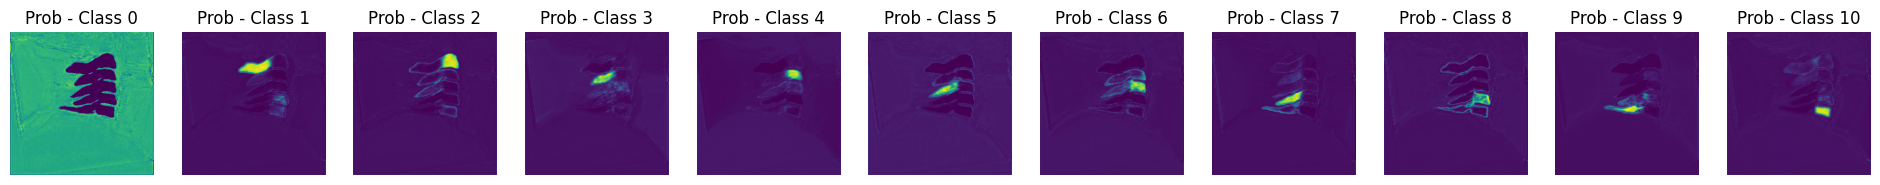

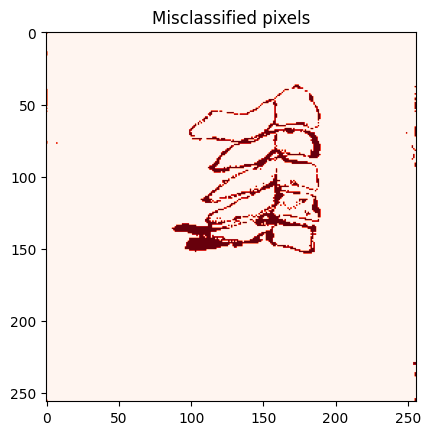

train_losses 0.7889504055182139
val_losses 0.7375477064739574
lr 0.0001017999999999998
Validation loss decreased (1.079732 --> 0.737548).  Saving model ...
***************************
modelname:model_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count9
model_dir =  model/20251115-CLA-MCU-Net-CE
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Net-CE/fold1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Net-CE/fold1/N1-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-4.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Ne

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

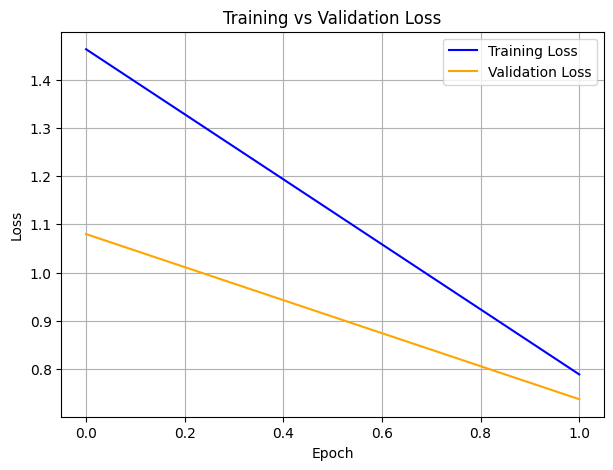

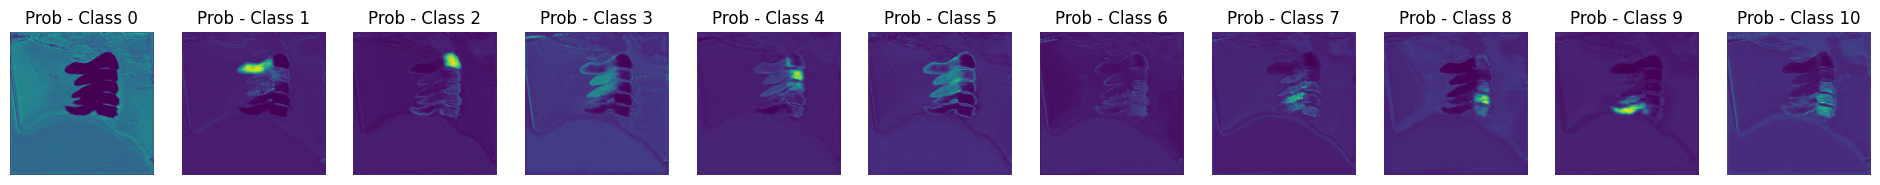

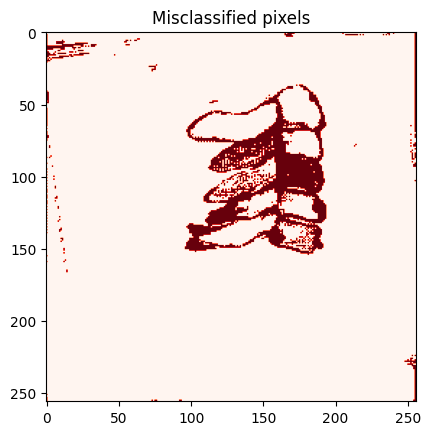

train_losses 1.6656566674059088
val_losses 1.3945000138547685
lr 0.0001
Validation loss decreased (inf --> 1.394500).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

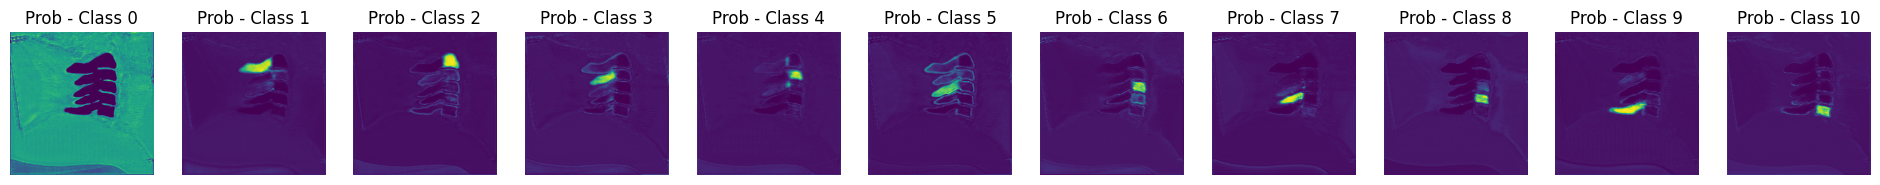

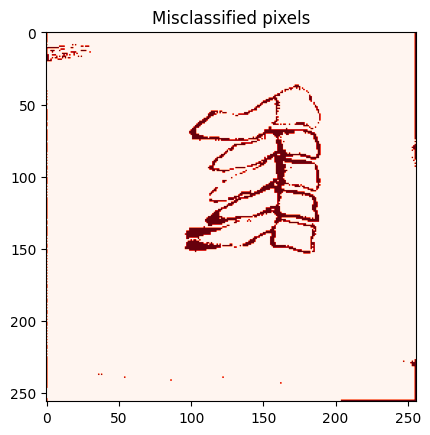

train_losses 0.9542416830857595
val_losses 1.0173399176862505
lr 0.0001017999999999998
Validation loss decreased (1.394500 --> 1.017340).  Saving model ...
***************************
modelname:model_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count9
model_dir =  model/20251115-CLA-MCU-Net-CE
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Net-CE/fold2/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Net-CE/fold2/N1-8.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-8.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251115-CLA-MCU-Ne

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

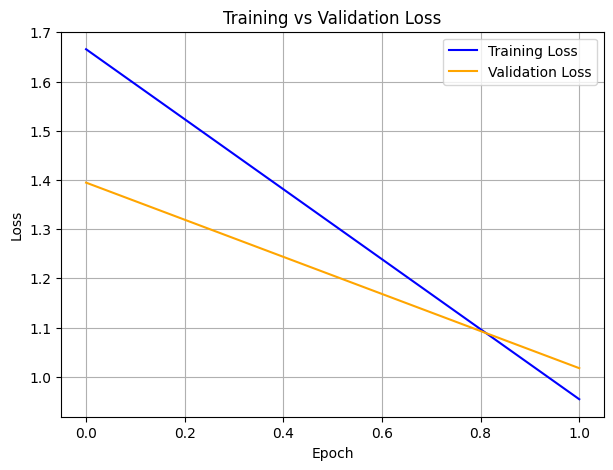

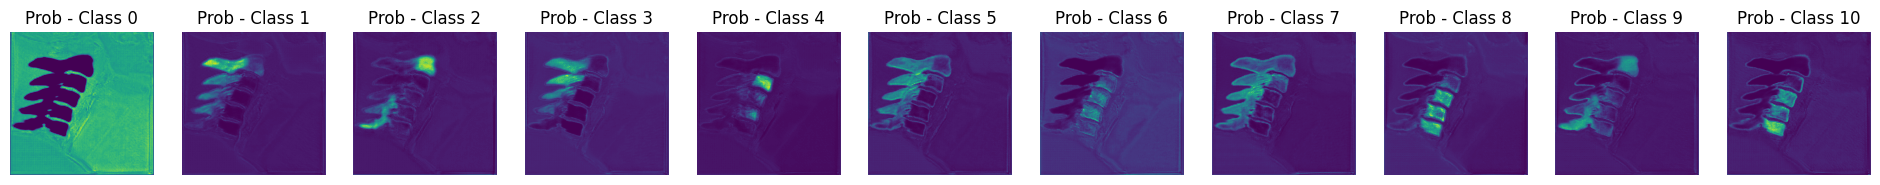

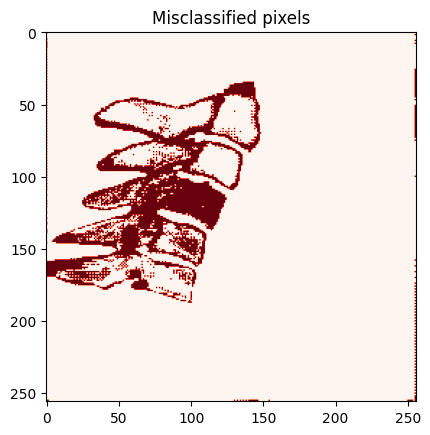

train_losses 1.529683410579508
val_losses 1.0898516320519978
lr 0.0001
Validation loss decreased (inf --> 1.089852).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
## Execution
from dataArrange import dataRearrange1
## Test Learn_EA without annealing
# training transformations and augmentations

transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')


# removal = ["N1-2", "N1-4", "N5-6", "N2-9"]
# X = [item for item in X if item not in removal]
# y_file_names = [item for item in y_file_names if item not in removal]

y = [label_group[:2] for label_group in y_file_names]



X = np.array(X)
y = np.array(y)


print(X)
print(y)



if CROSS_VAL:
    skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
    # each case same division
    #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # Split the data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Split the training data further into train and validation ( 1/3 split)
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        
        input_train = X_train_final
        input_name_val = X_val
        print("Cross validation: " + str(CROSS_VAL))
        print(f"Fold: {fold} out of {N_SPLIT}")
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
        
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        
        #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
         
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold)
        mConv_predict(X_test, fold)
        
        # Force garbage collection 
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    
    X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Cross validation: " + str(CROSS_VAL))
    print("Augmentation: " + str(AUGMENTED))
    if AUGMENTED:
        print("Augmentation amount: " + str(AUGMENTATION))
    print("Training: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
        
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print()
    
    if AUGMENTED:
        ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
        ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
        repeated_items_train = np.repeat(input_train, AUGMENTATION)
        suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
        input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
        
        #Custom Arranging for training dataset because of the augmentation order
        input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
        repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
        suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
        input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
    
    
    
    # # ### lastly added for weig
    # ht management
    # weights = weights.view(1, 1, 1, -1)  # Reshape for broadcasting
    
    # #making pytorch tensor
    # input_dataset = torch.tensor(input_dataset, dtype=torch.float32)
    # input_dataset_val = torch.tensor(input_dataset_val, dtype=torch.float32)
    # weights = torch.tensor(weights, dtype=torch.float32)
    
    # input_dataset = input_dataset * weights
    # input_dataset_val = input_dataset_val * weights
    # input_dataset = input_dataset.numpy()
    # input_dataset_val = input_dataset_val.numpy()
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0)
    mConv_predict(X_test)
    
    # Force garbage collection
    gc.collect()

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    

In [ ]:
# df_optuna = pd.DataFrame(columns = ['Dice_importance', 'CE_importance', "Dice"])
# def objective(trial):
#     N_BLOCK = 5
#     LR = 0.003
                                                                                                        
#     OUTPUT_DIR = '20250528-DiCELossOptimization'
    
#     print(f"Trial {trial.number}")

#     IN_CHANNEL = 108

#     AUGMENTED = False
#     AUGMENTATION  =  30


#     CROSS_VAL = False
#     N_SPLIT = 4
    
#     DICE_IMPORTANCE = trial.suggest_float("dice_importance", 1.0, 100.0)
#     CE_IMPORTANCE = trial.suggest_float("ce_importance", 1.0, 100.0)
       
    
#     dice_val = executeExperiment()
    
#     #df_optuna.add([DICE_IMPORTANCE, CE_IMPORTANCE, dice_val])
#     return dice_val
    
# import optuna

# # Create a study to minimize or maximize the metric
# study = optuna.create_study(direction='maximize')  # or 'minimize' based on your metric
# study.optimize(objective, n_trials = 360)
# #df_optuna.to_csv("optuna_optimization_loss_function.csv") 
    
    


In [ ]:
# small add
# print(study.best_params)
# study.best_value